In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy
from notebook_utils import load_results_data, add_avg_subject, create_result_graph

In [2]:
all_data = load_results_data()

MODEL_ORDER = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
               "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "lxmert", "vilt", "resnet-50-glow", "bge", "resnet-and-bge", "glow", "glow-contrastive"]

all_data = all_data[all_data.model.isin(MODEL_ORDER)]
all_data

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649.0,pairwise_acc_captions,0.860455,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649.0,pairwise_acc_images,0.884472,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649.0,pairwise_acc_mean,0.872464,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,anatomical_lang,11150.0,pairwise_acc_captions,0.809731,bert-base-uncased_lang
4,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,anatomical_lang,11150.0,pairwise_acc_images,0.797930,bert-base-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...
20858,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,anatomical_visual_high_level,11205.0,pairwise_acc_images,0.892340,vit-l-16_vision
20859,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,anatomical_visual_high_level,11205.0,pairwise_acc_mean,0.801863,vit-l-16_vision
20860,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,anatomical_visual_low_level,9953.0,pairwise_acc_captions,0.615942,vit-l-16_vision
20861,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,anatomical_visual_low_level,9953.0,pairwise_acc_images,0.907246,vit-l-16_vision


In [3]:
all_data_avg = add_avg_subject(all_data)
all_data_avg = all_data_avg[all_data_avg.subject == "average"]

In [4]:
# ref performance order:
#['random-flava', 'resnet-152', 'vit-b-16', 'vit-l-16', 'resnet-18', 'resnet-50', 'dino-giant', 'dino-large', 'dino-base', 'bert-large-uncased', 'bert-base-uncased',
# 'llama2-7b', 'mixtral-8x7b', 'mistral-7b', 'llama2-13b', 'gpt2-small', 'gpt2-medium', 'gpt2-xl', 'gpt2-large', 'visualbert', 'bridgetower-large', 'clip', 'flava', 'imagebind', 'lxmert', 'vilt']
FEAT_OPTIONS = ["vision", "lang", "vision+lang", "matched"]

def calc_model_feat_order(data):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in FEAT_OPTIONS:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

for model in MODEL_ORDER:
    print(model, end=" ")

random-flava vit-b-16 vit-l-16 resnet-18 resnet-50 resnet-152 dino-base dino-large dino-giant bert-base-uncased bert-large-uncased llama2-7b llama2-13b mistral-7b mixtral-8x7b gpt2-small gpt2-medium gpt2-large gpt2-xl visualbert bridgetower-large clip flava imagebind lxmert vilt resnet-50-glow bge resnet-and-bge glow glow-contrastive 

In [5]:
distance_metric = 'cosine'
METRICS = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images']


In [6]:
def get_short_label_text(label, cut_labels=True):
    text = label.get_text().split('_')[0]
    if cut_labels and (len(text) > 10):
        text = f"{'-'.join(text.split('-')[:-1])}-\n{text.split('-')[-1]}"
    return text
    
def plot_metric_catplot(data, kind="bar", x_variable="model_feat", order=None, row_variable="subject", row_order=None, col_variable=None, hue_variable="model_feat", hue_order=None, metrics=["pairwise_acc_mean"], ylim=(0.5, 1),
                        plot_legend=True, palette=None, noise_ceilings=None, hatches=None, legend_title="Model features modality", height=4, aspect=4, legend_bbox=(0.05,1), rotation=80, cut_labels=True):
    data_filtered = data[data.metric.isin(metrics)]

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, row_order=row_order, col=col_variable, height=height, aspect=aspect, hue=hue_variable, hue_order=hue_order,
                    palette=palette, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
   
    g._legend.remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9), ncol=2)
        lgd = g.fig.legend(ncol=2, title=legend_title, loc="upper left", bbox_to_anchor=legend_bbox)#, bbox_to_anchor=(0.02, 0.95), ncol=9)
        bbox_extra_artists = (lgd,)

    for i in range(len(g.axes[-1])):
        last_axis = g.axes[-1][i]
        last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
        
    g.set(ylim=ylim, ylabel="pairwise_acc_mean", xlabel='')
    
    plt.tight_layout()
    
    return g, data_filtered, lgd

# Decoding with GloW

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:61: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, row_order=row_order, col=col_variable, height=height, aspect=aspect, hue=hue_variable, hue_order=hue_order,
/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:23: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=

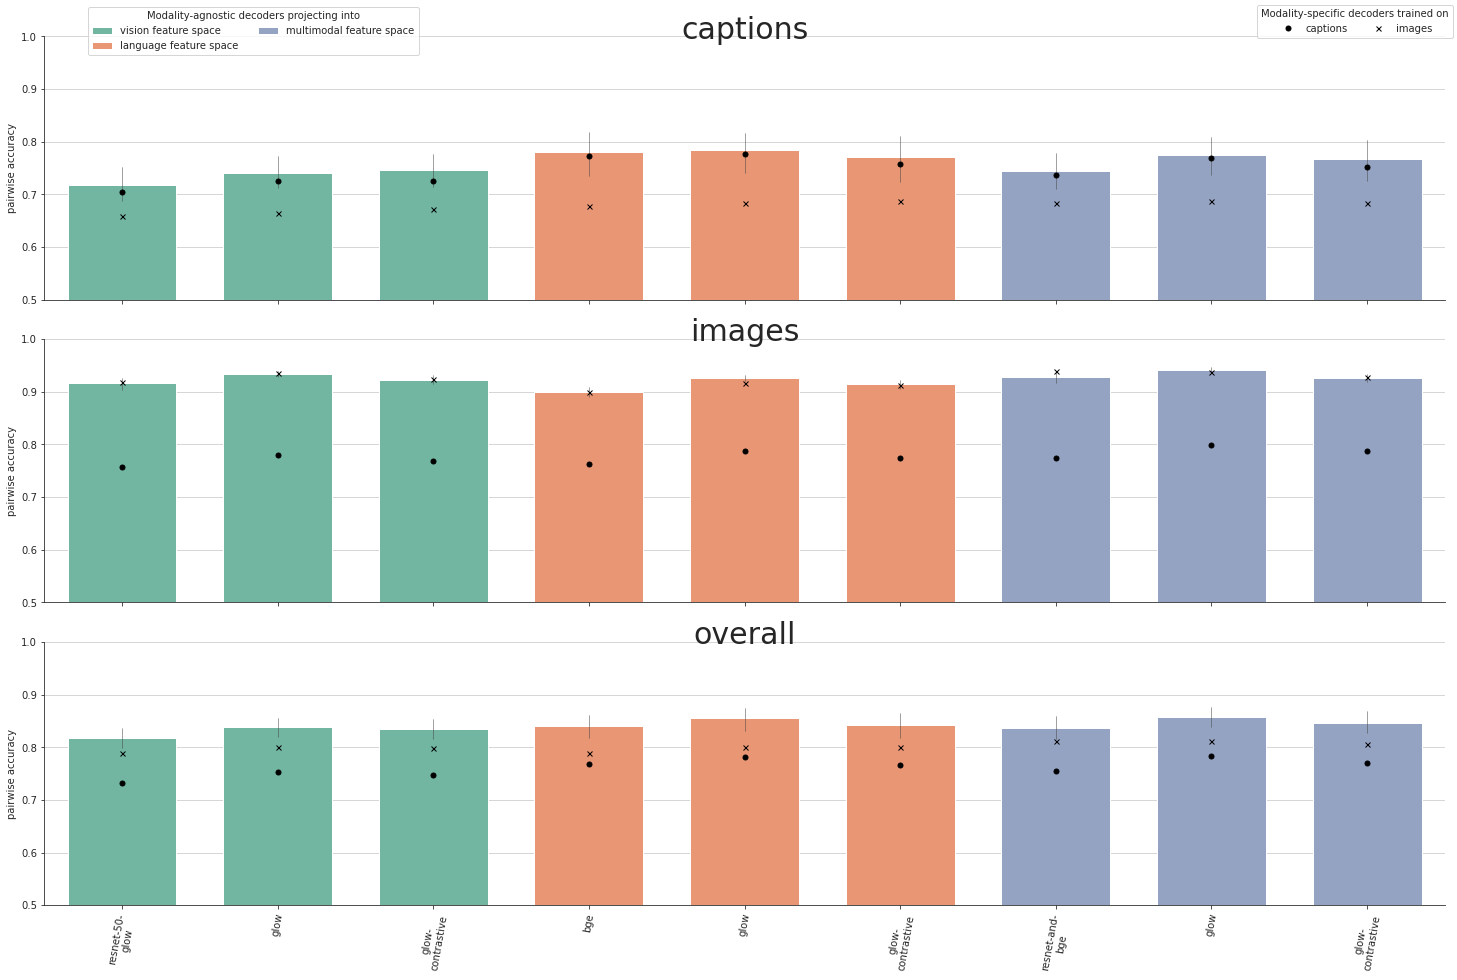

In [7]:
feat_order = ["vision feature space", "language feature space", "multimodal feature space"]

model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_vision+lang"]
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(model_feats_exluded)].copy()

# models_to_plot = ["resnet-50-glow", "bge", "resnet-and-bge", "glow", "glow-contrastive"]
model_feat_order = ['resnet-50-glow_vision', 'glow_vision', 'glow-contrastive_vision', 'bge_lang', 'glow_lang', 'glow-contrastive_lang', 'resnet-and-bge_vision+lang', 'glow_vision+lang', "glow-contrastive_vision+lang"]
data_to_plot = data_to_plot[data_to_plot.model_feat.isin(model_feat_order)]
data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision feature space", "lang": "language feature space", "vision+lang": "multimodal feature space"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
# model_feat_order = calc_model_feat_order(data_to_plot)
# model_feat_order = ['resnet-50-glow_vision', 'glow_vision', 'bge_lang', 'glow_lang', 'resnet-and-bge_vision+lang', 'glow_vision+lang']
metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", "pairwise_acc_mean"]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into")
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)